# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
indat=pd.read_csv("https://covid.ourworldindata.org/data/ecdc/full_data.csv")

def expslope(x,step):
  y=np.zeros((len(x),))
  for i in np.arange(step,len(x)):
    if (x[i-step]>0.0 and x[i]>0.0):
      y[i]=np.log(1.0*x[i]/x[i-step])/(step+0.0001)
  return y

indat["diff"]=(pd.to_datetime(indat["date"])-pd.to_datetime('2020-03-01')).dt.days

# Estimate Growth Rate with Gaussian Process

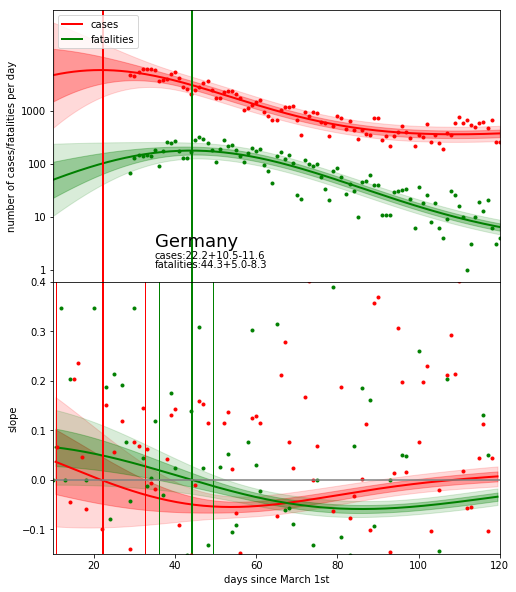

In [7]:
import sklearn as skl
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,Matern,WhiteKernel
      

    
alphan=0.99
imin=90
xmax=120
loc='Austria'
loc='Germany'
loc='Romania'
loc='Spain'
#loc='Austria'
#loc='Belgium'
loc="Germany"
#loc="United Kingdom"
dg=indat[(indat['location']==loc)][["diff","new_cases"]].to_numpy()

dgd=indat[(indat['location']==loc)][["diff","new_deaths"]].to_numpy()
dg=dg+(dg==0)
dgd=dgd+(dgd==0)

kernel=1.0*RBF(length_scale=1.0, length_scale_bounds=(0.01, 50.0))+WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
kerneld=1.0*RBF(length_scale=1.0, length_scale_bounds=(0.01, 50.0))+WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
#kernel=1.0*Matern(length_scale=50.0, length_scale_bounds=(25.0, 50.0))

gpr=GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=50,alpha=alphan)#2.9
gprd=GaussianProcessRegressor(kernel=kerneld,n_restarts_optimizer=50,alpha=alphan)#2.9
#reshaping required
#print((dgd[imin:,1]))
#print(np.log(dg[imin:,1]))
gpr.fit(dg[imin:,0][:, np.newaxis],np.log(np.abs(dg[imin:,1])))
#print dgd[imin:,0][:, np.newaxis]
#print np.log(dgd[imin:,1])
gprd.fit(dgd[imin:,0][:, np.newaxis],np.log(dgd[imin:,1]))

x=np.linspace(10,xmax,200)
y,yerr=gpr.predict(x.reshape(-1,1),return_std=True)
yd,yerrd=gprd.predict(x.reshape(-1,1),return_std=True)

plt.figure(figsize=(8,10))
ax=plt.subplot(211)

plt.plot(x,y,'r',lw=2,label='cases')
plt.fill_between(x,y-yerr,y+yerr,alpha=0.3,color='r')
plt.fill_between(x,y-2.0*yerr,y+2.0*yerr,alpha=0.15,color='r')
plt.plot(dg[imin:,0],np.log(dg[imin:,1]),'ro',ms=3)

plt.plot(x,yd,'g',lw=2,label='fatalities')
plt.fill_between(x,yd-yerrd,yd+yerrd,alpha=0.3,color='g')
plt.fill_between(x,yd-2.0*yerrd,yd+2.0*yerrd,alpha=0.15,color='g')
plt.plot(dg[imin:,0],np.log(dgd[imin:,1]),'go',ms=3)

ax.set_yticks([np.log(1),np.log(10),np.log(100),np.log(1000)])
ax.set_yticklabels(['1','10','100','1000'])

#plt.errorbar(dg[imin:,0],np.log(dg[imin:,1]),0.02*np.log(dg[imin:,1]),fmt='o',ms=1)
plt.xlim(10,xmax)
ax.set_xticks([])
plt.legend(loc='upper left')
plt.ylabel('number of cases/fatalities per day')
#plt.patches.rectangle((30,np.log(1)),1,5,color='r')
plt.text(35,1,loc,fontsize=18)#ukagetab[ukagetab["Code"]==a]["2018 people per sq. km"].to_numpy()[0]
############################################################
plt.subplot(212)
y,yerr=gpr.predict(x.reshape(-1,1),return_cov=True)
yd,yerrd=gprd.predict(x.reshape(-1,1),return_cov=True)
slope=(y[2:]-y[:-2])/(x[2:]-x[:-2])
sloped=(yd[2:]-yd[:-2])/(x[2:]-x[:-2])
slopeerr=np.zeros((len(slope),))
slopeerrd=np.zeros((len(sloped),))
for i in np.arange(1,len(slope)+1):
  slopeerr[i-1]=np.sqrt(yerr[i+1,i+1]+yerr[i-1,i-1]-2.0*yerr[i+1,i-1])
  slopeerrd[i-1]=np.sqrt(yerrd[i+1,i+1]+yerrd[i-1,i-1]-2.0*yerrd[i+1,i-1])

plt.plot(x[1:-1],slope,'r',lw=2)
plt.fill_between(x[1:-1],slope-2.0*slopeerr,slope+2.0*slopeerr,alpha=0.15,color='r')
plt.fill_between(x[1:-1],slope-slopeerr,slope+slopeerr,alpha=0.3,color='r')

plt.plot(x[1:-1],sloped,'g',lw=2)
plt.fill_between(x[1:-1],sloped-2.0*slopeerrd,sloped+2.0*slopeerrd,alpha=0.15,color='g')
plt.fill_between(x[1:-1],sloped-slopeerrd,sloped+slopeerrd,alpha=0.3,color='g')


imin=next(x for x, val in enumerate(slope) if val < 0.0) 
plt.axvline(x=x[imin+1],color='r',lw=2)
ax.axvline(x=x[imin+1],color='r',lw=2)
iminh=next(x for x, val in enumerate(slope+slopeerr) if val < 0.0) 
plt.axvline(x=x[iminh+1],color='r',lw=1)
iminl=next(x for x, val in enumerate(slope-slopeerr) if val < 0.0) 
plt.axvline(x=x[iminl+1],color='r',lw=1)

scase='cases:'+'{:.1f}'.format(x[imin+1])+'+'+'{:.1f}'.format(x[iminh+1]-x[imin+1])+'-'+'{:.1f}'.format(x[imin+1]-x[iminl+1])
ax.text(35,0.5,scase)

imin=next(x for x, val in enumerate(sloped) if val < 0.0) 
plt.axvline(x=x[imin+1],color='g',lw=2)
ax.axvline(x=x[imin+1],color='g',lw=2)
iminh=next(x for x, val in enumerate(sloped+slopeerrd) if val < 0.0) 
plt.axvline(x=x[iminh+1],color='g',lw=1)
iminl=next(x for x, val in enumerate(sloped-slopeerrd) if val < 0.0) 
plt.axvline(x=x[iminl+1],color='g',lw=1)
sdeaths='fatalities:'+'{:.1f}'.format(x[imin+1])+'+'+'{:.1f}'.format(x[iminh+1]-x[imin+1])+'-'+'{:.1f}'.format(x[imin+1]-x[iminl+1])
ax.text(35,0.1,sdeaths)


'''
for i in np.arange(100):
  y=gpr.sample_y(x.reshape(-1,1),random_state=i)
  plt.plot(x[1:-1],(y[2:]-y[:-2])/(x[2:]-x[:-2]),'g',alpha=0.005)
'''
plt.plot(dg[:,0],expslope(dg[:,1],2),'ro',ms=3);
plt.plot(dg[:,0],expslope(dgd[:,1],2),'go',ms=3);

plt.xlim(10,xmax)
plt.ylim(-0.15,0.4)
plt.axhline(y=0,color='gray')

plt.subplots_adjust(wspace=0,hspace=0)

plt.ylabel('slope')
plt.xlabel('days since March 1st')

#plt.subplot(121)


plt.savefig('Figures/'+loc+'.pdf',bbox_inches='tight')



Weekly modulation

Text(0.5,0,'days since March 1st')

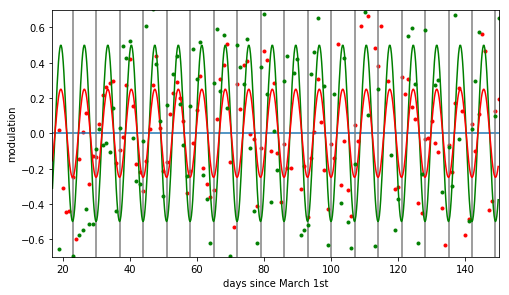

In [25]:
#gpr.fit(dg[imin:,0][:, np.newaxis],np.log(np.abs(dg[imin:,1])))
#gprd.fit(dgd[imin:,0][:, np.newaxis],np.log(dgd[imin:,1]))

x=np.linspace(10,xmax,200)
y,yerr=gpr.predict(dg[imin:,0][:, np.newaxis],return_std=True)
yd,yerrd=gprd.predict(dgd[imin:,0][:, np.newaxis],return_std=True)

plt.figure(figsize=(8,10))
ax=plt.subplot(211)


#print np.exp(y),len(y)
#print dg[imin:,1],len(dg[imin:,1])
#print np.exp(y)-dg[imin:,1]
plt.plot(dg[imin:,0],dg[imin:,1]/np.exp(y)-1,'ro',lw=2,label='cases',ms=3)
#plt.fill_between(x,y-yerr,y+yerr,alpha=0.3,color='r')
#plt.fill_between(x,y-2.0*yerr,y+2.0*yerr,alpha=0.15,color='r')
#plt.plot(dg[imin:,0],np.log(dg[imin:,1]),'ro',ms=3)

plt.axhline(y=0)

i0=23
for i in np.arange(i0,150,7):
    plt.axvline(x=i,color='gray')
    
xxx=np.arange(17,150,0.2)
plt.plot(xxx,np.sin(np.pi*(xxx-23)/7.0)**2.0-0.5,'g')
plt.plot(xxx,0.5*(np.sin(np.pi*(xxx-23)/7.0)**2.0-0.5),'r')
plt.plot(dgd[imin:,0],dgd[imin:,1]/np.exp(yd)-1,'go',lw=2,label='fatalities',ms=3)
#plt.fill_between(x,yd-yerrd,yd+yerrd,alpha=0.3,color='g')
#plt.fill_between(x,yd-2.0*yerrd,yd+2.0*yerrd,alpha=0.15,color='g')
#plt.plot(dg[imin:,0],np.log(dgd[imin:,1]),'go',ms=3)

plt.ylim(-0.7,0.7)
plt.xlim(17,150)
plt.ylabel('modulation')
plt.xlabel('days since March 1st')


## Sample from Distribution

(33.81909547738693, 2.4120603015075375, 2.4120603015075375)


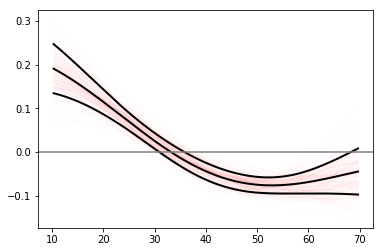

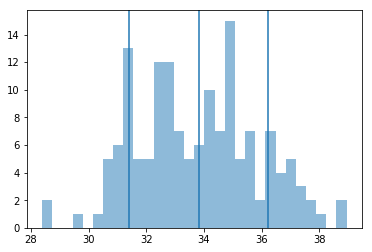

In [188]:
plt.figure()

#print(len(y))
#print(len(x))
#print(y.transpose()[0])

nmc=150
x0=np.zeros((nmc,))
for i in np.arange(nmc):
    y=gpr.sample_y(x.reshape(-1,1),n_samples=1,random_state=i)
    y=y.transpose()[0]
    slope=(y[2:]-y[:-2])/(x[2:]-x[:-2])
    plt.plot(x[1:-1],slope,'r',alpha=0.01)
    #print(y.reshape(1,-1))
    #print(slope)
    imin=next(x for x, val in enumerate(slope) if val < 0.0)
    x0[i]=x[imin+1]


y,yerr=gpr.predict(x.reshape(-1,1),return_cov=True)
slope=(y[2:]-y[:-2])/(x[2:]-x[:-2])
slopeerr=np.zeros((len(slope),))
for i in np.arange(1,len(slope)+1):
  slopeerr[i-1]=np.sqrt(yerr[i+1,i+1]+yerr[i-1,i-1]-2.0*yerr[i+1,i-1])

plt.plot(x[1:-1],slope,'k',lw=2)
plt.plot(x[1:-1],slope+2.0*slopeerr,'k',lw=2)
plt.plot(x[1:-1],slope-2.0*slopeerr,'k',lw=2)

    

#plt.xlim(10,70)
#plt.ylim(-0.15,0.4)
plt.axhline(y=0,color='gray')


#imin=next(x for x, val in enumerate(slope) if val < 0.0) 
#plt.axvline(x=x[imin+1],color='g',lw=2)
plt.figure()

plt.hist(x0,30,alpha=0.5)
xp=np.percentile(x0,[16,50,86])
plt.axvline(x=xp[0])
plt.axvline(x=xp[1])
plt.axvline(x=xp[2])
print(xp[1],xp[1]-xp[0],xp[2]-xp[1])

# Death Rates

In [8]:
dir="http://www.damtp.cam.ac.uk/user/tb561/Corona/"
dir="CoronaUK/"

agetablemale=pd.read_excel(dir+"deathsyoauk2018.xls",sheet_name="Table 1",header=3,usecols="A:AT",nrows=104)
agetablefemale=pd.read_excel(dir+"deathsyoauk2018.xls",sheet_name="Table 2",header=3,usecols="A:AT",nrows=104)

In [9]:
#agetablemale

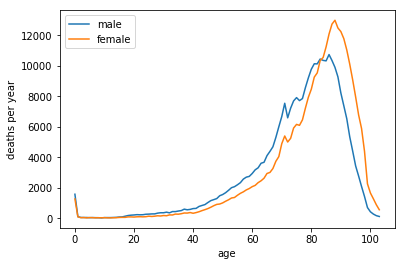

In [24]:
nm=agetablemale[2018].to_numpy()
nf=agetablefemale[2018].to_numpy()
ag=agetablemale['Age'].to_numpy()
#plt.hist(ag,nm)

plt.plot(ag,nm,label='male')
plt.plot(ag,nf,label='female')
plt.xlabel('age')
plt.ylabel('deaths per year')
plt.legend(loc='upper left')

In [11]:
ukagetab=pd.read_excel(dir+"ukmidyearestimates20182019ladcodes.xls",sheet_name="MYE1",header=11,usecols="A:D",nrows=19)
ukagetab.columns=['Age Groups','a','b','c']

In [13]:
nagebin=len(ukagetab["Age Groups"])
agebinb=np.zeros((nagebin+1,))
agebincnt=np.zeros((nagebin,4))

for i in np.arange(nagebin-1):
  agebinb[i]=np.int(ukagetab["Age Groups"][i].split('-')[0])

agebinb[-2]=90
agebinb[-1]=110


for i in np.arange(nagebin):
  agebincnt[i,0]=np.sum(ag*(ag>=agebinb[i])*(ag<agebinb[i+1]))/np.sum((ag>=agebinb[i])*(ag<agebinb[i+1]))
  agebincnt[i,1]=np.sum((nm+nf)*(ag>=agebinb[i])*(ag<agebinb[i+1]))
  agebincnt[i,2]=np.sum((nm)*(ag>=agebinb[i])*(ag<agebinb[i+1]))
  agebincnt[i,3]=np.sum((nf)*(ag>=agebinb[i])*(ag<agebinb[i+1]))
  #print(i,'\t',agebinb[i],'\t',agebinb[i+1],'\t',sum((ag>=agebinb[i])*(ag<agebinb[i+1])))


#print(agebincnt)

Text(0.5,0,'Age')

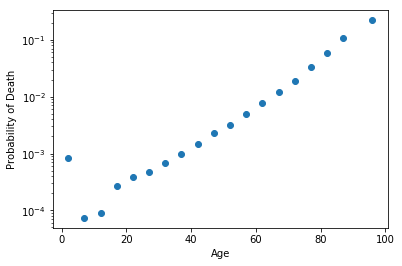

In [14]:
plt.semilogy(agebincnt[:,0],agebincnt[:,1]/ukagetab['a'],'o')
plt.ylabel('Probability of Death')
plt.xlabel('Age')

Index([u'0.13', u'0.14', u'0.15', u'0.16', u'0.17', 1, u'1.1', u'0.18'], dtype='object')


Text(0.5,0,'Days since March 1st')

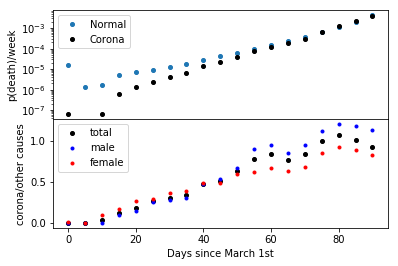

In [15]:
deathbyage=pd.read_excel("CoronaUK/publishedweek212020.xlsx",sheet_name="Covid-19 - Weekly registrations",header=11,usecols="P:W",nrows=19)
print(deathbyage.columns)
#deathbyage.columns=['N','M','O','P','R']

deathbyagem=pd.read_excel("CoronaUK/publishedweek212020.xlsx",sheet_name="Covid-19 - Weekly registrations",header=33,usecols="P:W",nrows=19)
#deathbyagem.columns=['N','M','O','P','R']

deathbyagef=pd.read_excel("CoronaUK/publishedweek212020.xlsx",sheet_name="Covid-19 - Weekly registrations",header=55,usecols="P:W",nrows=19)
#deathbyagef.columns=['N','M','O','P','R']


#dba=deathbyage['N'].to_numpy()+deathbyage['M'].to_numpy()+deathbyage['O'].to_numpy()+deathbyage['P'].to_numpy()+deathbyage['R'].to_numpy()
#dbam=deathbyagem['N'].to_numpy()+deathbyagem['M'].to_numpy()+deathbyagem['O'].to_numpy()+deathbyagem['P'].to_numpy()+deathbyagem['R'].to_numpy()
#dbaf=deathbyagef['N'].to_numpy()+deathbyagef['M'].to_numpy()+deathbyagef['O'].to_numpy()+deathbyagef['P'].to_numpy()+deathbyagef['R'].to_numpy()


dba=deathbyage.sum(axis=1).to_numpy()
dbam=deathbyagem.sum(axis=1).to_numpy()
dbaf=deathbyagef.sum(axis=1).to_numpy()

plt.subplot(211)
plt.semilogy(agebinb[:-1],agebincnt[:,1]/ukagetab['a']/52.0,'o',label='Normal',ms=4)
plt.semilogy(agebinb[:-1],dba/ukagetab['a']/4.0,'ko',label='Corona',ms=4)
plt.legend(loc='upper left')
plt.ylabel('p(death)/week')

plt.subplot(212)
plt.plot(agebinb[:-1],52.0*dba/agebincnt[:,1]/4.0,'ko',ms=4,label='total')
plt.plot(agebinb[:-1],52.0*dbam/agebincnt[:,2]/4.0,'bo',label='male',ms=3)
plt.plot(agebinb[:-1],52.0*dbaf/agebincnt[:,3]/4.0,'ro',label='female',ms=3)
plt.ylabel('corona/other causes')
plt.legend(loc='upper left')
plt.subplots_adjust(hspace=0)
plt.xlabel('Days since March 1st')

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in divide
  """Entry point for launching an IPython kernel.
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  


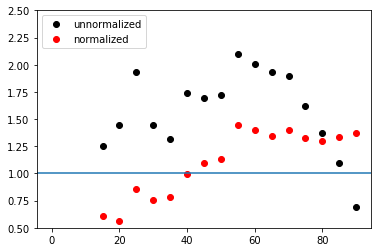

In [17]:
plt.plot(agebinb[:-1],(dbam*1.0)/(dbaf*1.0),'ko',label='unnormalized')
plt.plot(agebinb[:-1],(dbam*1.0)/(dbaf*1.0)/(agebincnt[:,2]/agebincnt[:,3]),'ro',label='normalized')
plt.axhline(y=1)
plt.ylim(0.5,2.5)
plt.legend(loc='upper left')

# Excess Deaths due to Corona

In [18]:
#deathbyweek=pd.read_excel(dir+"publishedweek1620201.xlsx",sheet_name="Weekly figures 2020",header=4,usecols="C:R",nrows=14)
deathbyweek=pd.read_excel(dir+"publishedweek262020.xlsx",sheet_name="Weekly figures 2020",header=4,usecols="C:AB",nrows=14)

54051
49607


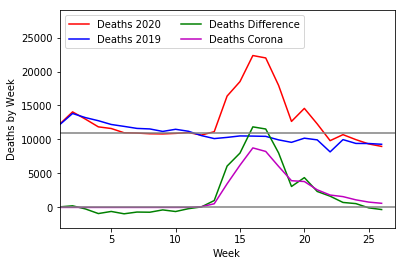

In [19]:
plt.plot(deathbyweek.columns.to_numpy(),deathbyweek.loc[3].to_numpy(),'r',label='Deaths 2020',ms=4)
plt.plot(deathbyweek.columns.to_numpy(),deathbyweek.loc[5].to_numpy(),'b',label='Deaths 2019',ms=4)
plt.plot(deathbyweek.columns.to_numpy(),deathbyweek.loc[3].to_numpy()-deathbyweek.loc[5].to_numpy(),'g',label='Deaths Difference',ms=4)
print(np.sum(deathbyweek.loc[3].to_numpy()-deathbyweek.loc[5].to_numpy()))
plt.plot(deathbyweek.columns.to_numpy(),deathbyweek.loc[13].to_numpy(),'m',label='Deaths Corona')
print(np.sum(deathbyweek.loc[13].to_numpy()))
plt.axhline(y=11000,color='gray')
plt.axhline(y=0,color='gray')
plt.legend(loc='upper left',ncol=2)
plt.ylabel('Deaths by Week')
plt.xlabel('Week')
plt.ylim(-3000,29000)
plt.xlim(1,27)
plt.savefig('deaths2020.png',bbox_inches='tight')

# Locally

In [20]:
indatukloc=pd.read_excel(dir+"HistoricDashboardData.xlsx",sheet_name="NHS Regions",header=7,usecols="B:AF")

3.150669002545206


Text(0,0.5,'cases per capita')

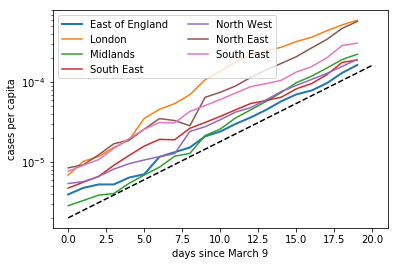

In [21]:
plt.semilogy(indatukloc[indatukloc["Area Name"]=="East of England"].to_numpy()[0,1:]/6.1E6,label="East of England",lw=2)#
plt.semilogy(indatukloc[indatukloc["Area Name"]=="London"].to_numpy()[0,1:]/8.9E6,label="London")#
plt.semilogy(indatukloc[indatukloc["Area Name"]=="Midlands"].to_numpy()[0,1:]/10.9E6,label="Midlands")#
plt.semilogy(indatukloc[indatukloc["Area Name"]=="South East"].to_numpy()[0,1:]/9.1E6,label="South East")#
plt.semilogy(indatukloc[indatukloc["Area Name"]=="North West"].to_numpy()[0,1:]/6.5E6,label="North West")#
plt.semilogy(indatukloc[indatukloc["Area Name"]=="North East and Yorkshire"].to_numpy()[0,1:]/2.6E6,label="North East")#
plt.semilogy(indatukloc[indatukloc["Area Name"]=="South East"].to_numpy()[0,1:]/5.6E6,label="South East")#
x=np.linspace(0,20,100)
plt.semilogy(x,2e-6*np.exp(0.22*x),'k--')
print(np.log(2.0)/0.22)
plt.legend(loc='upper left',ncol=2)
plt.xlabel('days since March 9')
plt.ylabel('cases per capita')

In [22]:
indatuk=pd.read_excel(dir+"HistoricDashboardData.xlsx",sheet_name="UTLAs",header=7,usecols="B:AT")

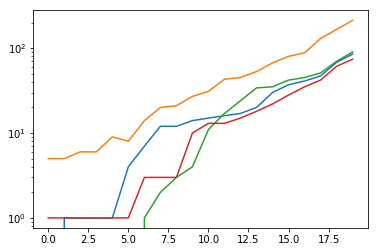

In [23]:
plt.semilogy(indatuk[indatuk["Area Name"]=="Cambridgeshire"].to_numpy()[0,1:],label="East of England")#
plt.semilogy(indatuk[indatuk["Area Name"]=="Essex"].to_numpy()[0,1:],label="East of England")#
plt.semilogy(indatuk[indatuk["Area Name"]=="Norfolk"].to_numpy()[0,1:],label="East of England")#
plt.semilogy(indatuk[indatuk["Area Name"]=="Suffolk"].to_numpy()[0,1:],label="East of England")#

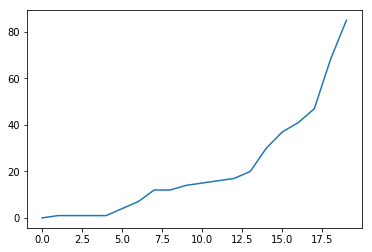

In [20]:
plt.plot(indatuk[indatuk["Area Name"]=="Cambridgeshire"].to_numpy()[0,1:],label="East of England")#